In [18]:
cd MF

/home/shse/Documents/stage_cnrs/mean-field-twoNW/Najwa/MF


In [19]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt
from transfer_functions.data import *
from graphs import *


from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

In [20]:
from MF_functions_clean import *

## First, build the MF architecture and set the right parameters


In [28]:
h=0.0001
T=0.005
Ntot=10000

number_of_populations=2 # variate this paramater, first are excitators and second inihibitors 
number_of_adaptive=1

p_con=np.ones((2,2))*(0.05) #np.ones((4,4))*(0.05) ou number_of_pop*0.05
#p_con[2][2]=0.6 #inh tres connecté 
#p_con[1][2]=p_con[2][1]=0 ## the two FS populations are not connected !
p_pois=np.ones(2)*0.05

''' Now params becomes a dictionary'''

#numb_par=28
params={}

params['diff']=[0,0] # by default nothing changes from neuron model
params['tstep']=5e-4 
params['numb_var']=number_of_populations**2+number_of_populations+number_of_adaptive#14 # total numb of var
# remove number_of_populations**2 for first order 
params['tauw']=[5e-1,1e-3] # tau_w
params['a']=[4e-9,0] # a 0,0
params['b']=[60e-12,0] # b 
params['El']=[-65e-3,-65e-3] # El -70e-3,-65e-3
params['total_size']=10000
params['size_subpop']=[8000,2000] 
params['numb_pop']=number_of_populations
params['numb_adapt']=number_of_adaptive
params['tau_e']=5e-3 # Tau_e
params['tau_i']=5e-3 # Tau_i
params['qe']=1e-9 # Qe
params['qi']=5e-9 # Qi
params['Ee']=0 # Ee
params['Ei']=-80e-3 # Ei
params['Gl']=[10e-9,10e-9]
params['Vthre']=[-50e-3,-50e-3]
params['Cm']=[200e-12,200e-12]



params['h']=h
params['T']=T
params['mu']=mu_V_dN_dp #_FO (for firdt order)

params['ext_inp']=[4.0,4.0] #external input : Poisson law, change params 2.5 HZ
params['inp_funct']=0 # input function
params['inp_par']=0 # input parameters
params['numb_sub_exc']=1# numb_sub_exc
params['numb_sub_inh']=1# numb_sub_inh
params['p_conn']=p_con # not anymore dp, here it is plain p 
params['p_pois']=p_pois



print(params)

{'diff': [0, 0], 'tstep': 0.0005, 'numb_var': 7, 'tauw': [0.5, 0.001], 'a': [4e-09, 0], 'b': [6e-11, 0], 'El': [-0.065, -0.065], 'total_size': 10000, 'size_subpop': [8000, 2000], 'numb_pop': 2, 'numb_adapt': 1, 'tau_e': 0.005, 'tau_i': 0.005, 'qe': 1e-09, 'qi': 5e-09, 'Ee': 0, 'Ei': -0.08, 'Gl': [1e-08, 1e-08], 'Vthre': [-0.05, -0.05], 'Cm': [2e-10, 2e-10], 'h': 0.0001, 'T': 0.005, 'mu': <function mu_V_dN_dp at 0x7fae82b118b0>, 'ext_inp': [4.0, 4.0], 'inp_funct': 0, 'inp_par': 0, 'numb_sub_exc': 1, 'numb_sub_inh': 1, 'p_conn': array([[0.05, 0.05],
       [0.05, 0.05]]), 'p_pois': array([0.05, 0.05])}


In [29]:
# Run the MF without adaptation a = b = 0 
#sys.path.append('../')

NTWK='CONFIG1'


NRN1='RS-cell'
NRN2='FS-cell'


TF_temp = load_transfer_functions_with_ALL_params(NRN1, NRN2, NTWK,params)
#TF_temp2 = load_transfer_functions(NRN3, NRN3, NTWK) # lazy to rewrite a load_TF function

TF=(TF_temp[0],TF_temp[1]) # TF defined as a tuple

params['TF']=TF


### Integration of the MF equations

##### Straight to second order !

In [30]:
#np.random.seed(10)
#x0=np.random.rand(7)*1e-5

x0=np.ones(7)*1e-5 
x0[0]=0.6 #ve exp 
x0[1]=7.0 #vi exp
x0[6]=x0[0]*60e-12 #w exp
print(x0)
time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]



print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    TF_inst=rk4_dN_dp_General(x0,params,time,MeanField_dN_dp) #MeanField_dN_dp est la fonction
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    

[6.0e-01 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 3.6e-11]
[6.0e-01 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 3.6e-11]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 



In [31]:
final_state=x_trace_RS[-1]
print(final_state)
#intégrer la dérivé , ici valeurs de nu_out 
#trouver pts fixes des, donné les freq vers les quelles elles 

[9.70169676e-01 6.83915579e+00 3.13982522e-02 3.52695065e-02
 3.52695065e-02 1.10891402e-01 6.42477982e-11]


In [8]:
final_state=TF_trace_RS[-1]
print(final_state)

[0.65291724 7.08212465]


### Load network activity to compare with MF

WARNING    "i" is an internal variable of group "synapses_3", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_4", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_5", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_6", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value array([3.60518534e-11, 3.61

--##Start simulation##--
--##End simulation##--
(1999,)
0.12137719279386308
0.22892430105532413


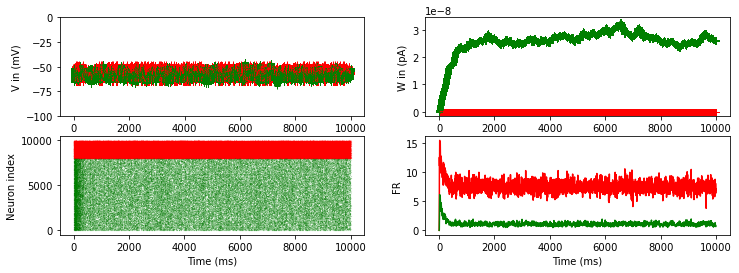

In [32]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *


#########################################################
#Define conditions for simulation
#start Brian scope:
start_scope()
#set dt value for integration (ms):
DT=0.1
seed(1)
defaultclock.dt = DT*ms

#total duration of the simulation (ms):
TotTime=10000
duration = TotTime*ms


#######################################################
#set the number of neuron of each population:
#inhibitory Fast Spiking (FS, population 1):
N1 = 2000
#Excitatory Regular Spiking (RS, population 2):
N2 = 8000


########################################################
# define equations of the model 
# define units of parameter
eqs='''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w:ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Pvar:1
Is:ampere
Cm:farad
gl:siemens
El:volt
a:siemens
tau_w:second
Dt:volt
Vt:volt
Ee:volt
Ei:volt
Tsyn:second
'''

########################################################
#Create populations:

	# Population 1 - FS

b1 = 0.0*pA #no adaptation for FS
#generate the population
G1 = NeuronGroup(N1, eqs, threshold='v > -47.5*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
#set values:
# initial values of variables:
G1.v = -65 *mV
G1.w = 0.0 *pA
G1.GsynI =0.0 *nS
G1.GsynE =0.0 *nS
# parameters values:
#soma:
G1.Cm = 200.*pF
G1.gl = 10.*nS
G1.El = -65.*mV
G1.Vt = -50.*mV
G1.Dt = 0.5*mV
G1.tau_w = 1.0 *ms #(no adapation, just to do not have error due to zero division)
G1.a = 0.0 *nS
G1.Is = 0.0  
#synapses:
G1.Ee =0.*mV
G1.Ei =-80.*mV
G1.Tsyn =5.*ms


# Population 2 - RS
b2 = 60.*pA
#generate the population
G2 = NeuronGroup(N2, eqs, threshold='v > -40.0*mV', reset='v = -65*mV; w += b2', refractory='5*ms',  method='heun')
#set values:
# initial values of variables:
G2.v = -65.*mV
G2.w = 0. *pA
G2.GsynI =0.0 *nS
G2.GsynE =0.0 *nS
# parameters values:
#soma:
G2.Cm = 200.*pF
G2.gl = 10.*nS
G2.El = -65.*mV
G2.Vt = -50.*mV
G2.Dt = 2.*mV
G2.tau_w = 500.*ms
G2.a = 4.*nS
G2.Is = 0.*nA  
#synpases:
G2.Ee =0.*mV
G2.Ei =-80.*mV
G2.Tsyn =5.*ms




#######################################################
# external drive---------------------------------------

P_ed=PoissonGroup(8000, rates= 4.0*Hz) 


#######################################################
# connections-------------------------------------------
#quantal increment when spike:
Qi=5.*nS
Qe=1.*nS

#probability of connection
prbC= 0.05 

#synapses from FS to RS:
S_12 = Synapses(G1, G2, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV')
S_12.connect('i!=j', p=prbC)
#synapses from FS to FS:
S_11 = Synapses(G1, G1, on_pre='GsynI_post+=Qi')
S_11.connect('i!=j',p=prbC)
#synapses from RS to FS:
S_21 = Synapses(G2, G1, on_pre='GsynE_post+=Qe')
S_21.connect('i!=j',p=prbC)
#synapses from RS to RS:
S_22 = Synapses(G2, G2, on_pre='GsynE_post+=Qe')
S_22.connect('i!=j', p=prbC)



#synapses from external drive to both populations:
S_ed_in = Synapses(P_ed, G1, on_pre='GsynE_post+=Qe')
S_ed_in.connect(p=prbC)

S_ed_ex = Synapses(P_ed, G2, on_pre='GsynE_post+=Qe')
S_ed_ex.connect(p=prbC)


######################################################
#set recording during simulation
#number of neuron record of each population:
Nrecord=1

M1G1 = SpikeMonitor(G1)
M2G1 = StateMonitor(G1, 'v', record=range(Nrecord))
M3G1 = StateMonitor(G1, 'w', record=range(Nrecord))
FRG1 = PopulationRateMonitor(G1)


M1G2 = SpikeMonitor(G2)
M2G2 = StateMonitor(G2, 'v', record=range(Nrecord))
M3G2 = StateMonitor(G2, 'w', record=range(Nrecord))
FRG2 = PopulationRateMonitor(G2)


#######################################################

#Run the simulation

print('--##Start simulation##--')
run(duration)
print('--##End simulation##--')


#######################################################
#Prepare recorded data

#organize arrays for raster plots:
RasG1 = np.array([M1G1.t/ms, [i+N2 for i in M1G1.i]])
RasG2 = np.array([M1G2.t/ms, M1G2.i])


#organize time series of single neuron variables
LVG1=[]
LwG1=[]
LVG2=[]
LwG2=[]
for a in range(Nrecord):
    LVG1.append(array(M2G1[a].v/mV))
    LwG1.append(array(M3G1[a].w/mamp))
    LVG2.append(array(M2G2[a].v/mV))
    LwG2.append(array(M3G2[a].w/mamp))

Ltime=array(M2G1.t/ms)

#Calculate population friing rate :

#function for binning:
def bin_array(array, BIN, time_array):
    N0 = int(BIN/(time_array[1]-time_array[0]))
    N1 = int((time_array[-1]-time_array[0])/BIN)
    return array[:N0*N1].reshape((N1,N0)).mean(axis=1)


BIN=5
time_array = np.arange(int(TotTime/DT))*DT

LfrG2=np.array(FRG2.rate/Hz)
TimBinned,popRateG2=bin_array(time_array, BIN, time_array),bin_array(LfrG2, BIN, time_array)

LfrG1=np.array(FRG1.rate/Hz)
TimBinned,popRateG1=bin_array(time_array, BIN, time_array),bin_array(LfrG1, BIN, time_array)


Lt1G1=array(M2G1.t/ms)
Lt2G1=array(M3G1.t/ms)
Lt1G2=array(M2G2.t/ms)
Lt2G2=array(M3G2.t/ms)

mean_LVG1 = np.mean(LVG1,axis=0)
max_LVG1 = np.max(LVG1,axis=0)
min_LVG1 = np.min(LVG1,axis=0)
mean_LwG1 = np.mean(LwG1,axis=0)
max_LwG1 = np.max(LwG1,axis=0)
min_LwG1 = np.min(LwG1,axis=0)
mean_LVG2 = np.mean(LVG2,axis=0)
max_LVG2 = np.max(LVG2,axis=0)
min_LVG2 = np.min(LVG2,axis=0)
mean_LwG2 = np.mean(LwG2,axis=0)
max_LwG2 = np.max(LwG2,axis=0)
min_LwG2 = np.min(LwG2,axis=0)

fig=plt.figure(figsize=(12,4))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)

for a in range(Nrecord):
    ax1.plot(Lt1G1, LVG1[a],'r:',linewidth=0.5)
    ax1.plot(Lt1G2, LVG2[a],'g:',linewidth=0.5)

for a in range(Nrecord):
    ax2.plot(Lt2G1, LwG1[a],'r:',linewidth=0.5)
    ax2.plot(Lt2G2, LwG2[a],'g:',linewidth=0.5)

ax1.plot(Lt1G1, mean_LVG1,'r',linewidth=2.0)
ax2.plot(Lt2G1, mean_LwG1,'r',linewidth=2.0)
ax1.plot(Lt1G2, mean_LVG2,'g',linewidth=2.0)
ax2.plot(Lt2G2, mean_LwG2,'g',linewidth=2.0)
ax1.plot(Lt1G1, max_LVG1,'r+',linewidth=0.5)
ax2.plot(Lt2G1, max_LwG1,'r+',linewidth=1.0)
ax1.plot(Lt1G2, max_LVG2,'g+',linewidth=0.5)
ax2.plot(Lt2G2, max_LwG2,'g+',linewidth=1.0)
ax1.plot(Lt1G1, min_LVG1,'r--',linewidth=0.5)
ax2.plot(Lt2G1, min_LwG1,'r--',linewidth=1.0)
ax1.plot(Lt1G2, min_LVG2,'g--',linewidth=0.5)
ax2.plot(Lt2G2, min_LwG2,'g--',linewidth=1.0)


ax1.set_ylim([-100, 0])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('V in (mV)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('W in (pA)')

ax3=fig.add_subplot(223)
ax3.plot(RasG1[0], RasG1[1], '.r',markersize=0.1)
ax3.plot(RasG2[0], RasG2[1], '.g',markersize=0.1)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Neuron index')

ax4=fig.add_subplot(224)
ax4.plot(TimBinned,popRateG1, 'r')
ax4.plot(TimBinned,popRateG2, 'g',markersize=0.1)
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('FR')

print(popRateG1.shape)
print(numpy.std(popRateG1[100:])/np.mean(popRateG1[100:]))
print(numpy.std(popRateG2[100:])/np.mean(popRateG2[100:]))
plt.show()
	

In [34]:
spikes[0]=[i+N2 for i in M1G1.i],M1G2.i
spikes[1]=M1G1.t/ms,M1G2.t/ms

WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
No h

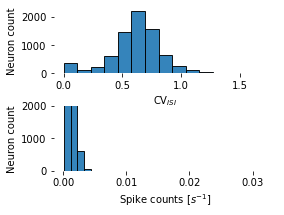

In [53]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = M1G2.i #commencer avec un 1er spike #par neuron
times = M1G2.t/ms
#t_2=8000.*ms
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in np.arange(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [10000*ms for 10000*ms in ts if 10000*ms  > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1 / np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');
axs[1].hist(meanFiringRates,bins=30, alpha=0.9, edgecolor='black',color='red');
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[0].set_yticks([0, 10, 20])

#axs[0].set_xlim(0, 1.6)
axs[1].set_ylim(0, 2000)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Mean Firing Rates [$s^{-1}$]")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.title('')

plt.subplots_adjust(hspace=0.5)

No handles with labels found to put in legend.


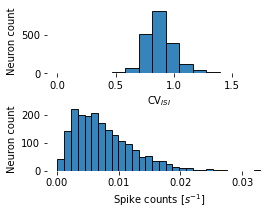

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = [i+N2 for i in M1G1.i] #commencer avec un 1er spike #par neuron
times = M1G1.t/ms
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in np.arange(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [t for t in ts if t > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1 / np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');
axs[1].hist(meanFiringRates, bins=30, alpha=0.9, edgecolor='black');
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[0].set_yticks([0, 10, 20])

#axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Spike counts [$s^{-1}$]")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)

In [74]:
arr=[popRateG1,popRateG2,LwG2,LVG1,LVG2,LfrG1,LfrG2,TimBinned,time_array]
np.save('2pop_data.npy', arr)
print("Your array has been saved to 2pop_data.npy")

WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
 [py.warnings]


Your array has been saved to 2pop_data.npy


In [77]:
popRateG1=data[0]
popRateG2=data[1]
LwG2=data[2]
LVG1=data[3]
LVG2=data[4]
LfrG1=data[5]
LfrG2=data[6]

### Draw distribution

0.9701696757225471 0.17719551959168744 6.839155785679677 0.33300360650753913


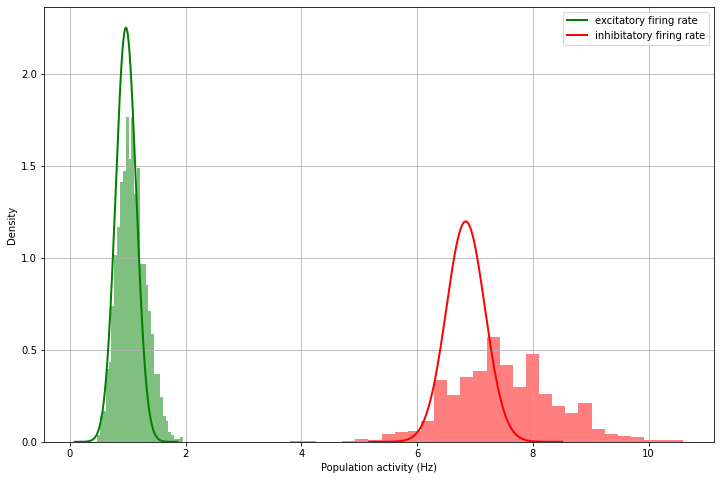

In [37]:
import scipy.stats

def gaussian(x,mean,std):
    return 1/(np.sqrt(2*math.pi*std**2))*math.exp(-(x-mean)**2/(2*std**2))

plt.figure(figsize=(12,8))

'''Remove transient'''

ST_popRateG1=popRateG1[int(len(popRateG1)/5)::] 
ST_popRateG2=popRateG2[int(len(popRateG2)/5)::]

plt.hist(ST_popRateG1, color='r',density= True, bins=30, alpha=0.5)
plt.hist(ST_popRateG2, color='g',density=True, bins=30, alpha=0.5)


mean_RS=final_state[0]
std_RS=np.sqrt(final_state[2])

mean_FS=final_state[1]
std_FS=np.sqrt(final_state[5])

print(mean_RS,std_RS,mean_FS,std_FS)

x_min_RS=mean_RS-5*std_RS #x_min_RS=mean_RS-5*std_RS
x_max_RS=mean_RS+5*std_RS

x_min_FS=mean_FS-5*std_FS
x_max_FS=mean_FS+5*std_FS

x_RS = np.linspace(x_min_RS, x_max_RS, 1000)
x_FS = np.linspace(x_min_FS, x_max_FS, 1000)

Distrib_RS=[]
Distrib_FS=[]


for i in range(len(x_RS)):
    Distrib_RS.append(gaussian(x_RS[i],mean_RS,std_RS))
    Distrib_FS.append(gaussian(x_FS[i],mean_FS,std_FS))


plt.plot(x_RS,Distrib_RS,color='g',lw=2,label='excitatory firing rate')
plt.plot(x_FS,Distrib_FS,color='r',lw=2, label='inhibitatory firing rate')
                             
plt.xlabel("Population activity (Hz)")
plt.grid(True)
plt.ylabel("Density")
plt.legend()
plt.show()

In [43]:
print(x_max_RS)

0.7664898782012017


In [38]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve=x_transp[0]#[1000:] # remove first 10000 elements
vi=x_transp[1]#[1000:]
cee=np.sqrt(x_transp[2])#[1000:]
cei=x_transp[3]#[1000:]
cie=x_transp[4]#[1000:]
cii=np.sqrt(x_transp[5])#[1000:]
w=x_transp[6]
#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])

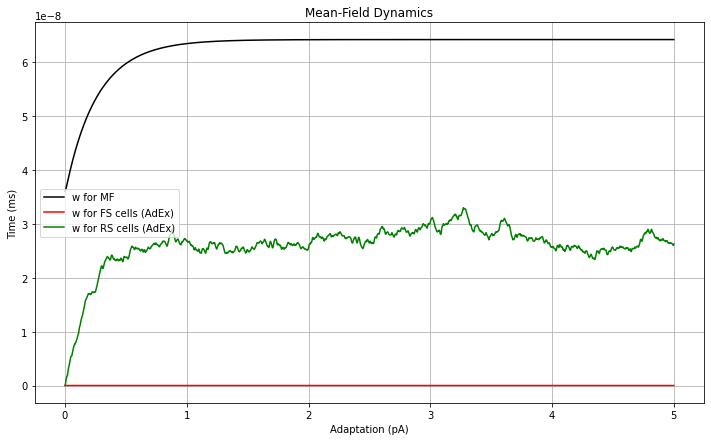

In [40]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace,w*1e3,color="black",label="w for MF")
for a in range(Nrecord):
    plt.plot(Ltime/2000, LwG1[a],'r',label='w for FS cells (AdEx)') 
    plt.plot(Ltime/2000, LwG2[a],'g',label='w for RS cells (AdEx)')

plt.xlabel("Adaptation (pA)")
plt.grid(True)
plt.ylabel("Time (ms)")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

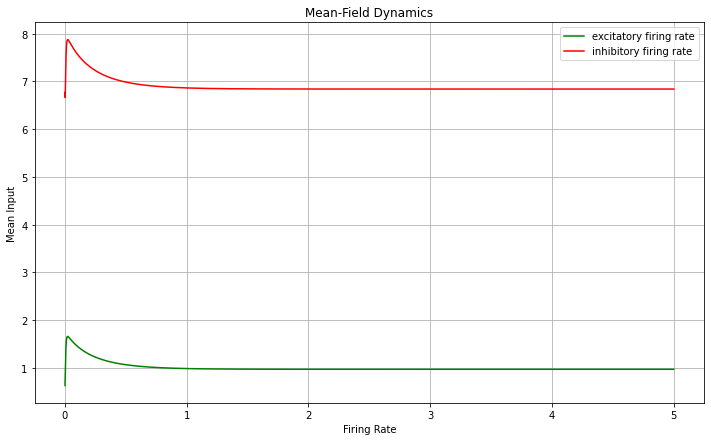

In [41]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace, ve, color="green", label="excitatory firing rate")
plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")

plt.xlabel("Firing Rate")
plt.grid(True)
plt.ylabel("Mean Input")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

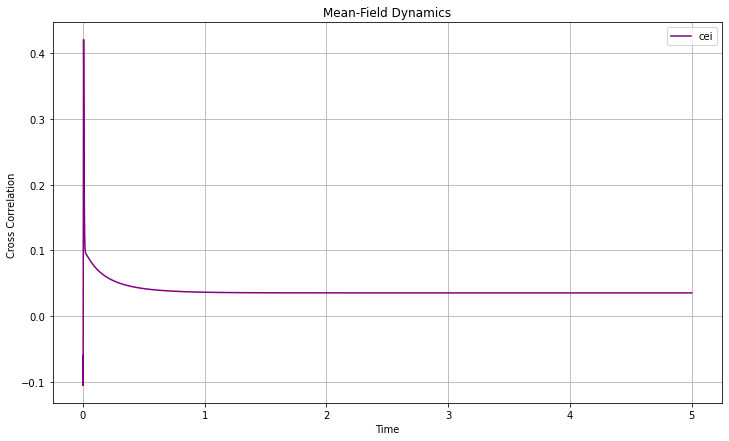

In [42]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace, cee, color="purple", label="cee")


plt.xlabel("Time")
plt.grid(True)
plt.ylabel("Cross Correlation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,)
#plt.xlim(0,0.1)
plt.show()

### Now... MAKE SOME NOISE !!!

##### ...(define noise functions and parameters)

In [43]:
def Ornstein_U_list(xi_0,dt,tot_time,tau):
    
    for i in np.arange(0,tot_time,dt):
        xi_0+=-dt*xi_0/tau+np.sqrt(dt)*np.random.randn()
        
###   To integrate in the MF, it needs to be written as a function

def OU_func_list(t,O_U_list):
    return O_U_list[t]

def Ornstein_func(xi_0,dt,tau):
    
    return xi_0-dt*xi_0/tau+np.sqrt(dt)*np.random.randn()
    

In [44]:
np.random.seed(10)
import datetime ### To keep track of time, might be useful, little bit like a watch
x0=np.ones(7)*1e-5
x0[0]=0.6 #ve exp 
x0[1]=7.0 #vi exp
x0[6]=x0[0]*60e-12 #w exp
print(x0)
time=0
t_trace2=[]
#T=0.005
#x_trace_aWITHTAU=[]
x_trace_RS_with_noise=[]
TF_trace_RS_with_noise=[]

drive=[]
params['tstep']=1e-4
params['T']=0.005


xi_exc=0 ## O_U process
xi_inh=0


print(x0)
time=0
    
for i in np.arange(0,10,params['tstep']):
    TF_inst= Euler_method_General(x0,params,time,MeanField_dN_dp_Hybrid_noise)
    
    xi_exc=Ornstein_func(xi_exc,params['tstep'],5e-4)
    xi_inh=Ornstein_func(xi_inh,params['tstep'],5e-4)

    params['ext_inp'][0]=2.0+10.5*xi_exc    
    params['ext_inp'][1]=2.0+10.5*xi_inh
    
    if (i%0.5==0):
        print('i = ', i, '\n')
        print('time : ', datetime.datetime.now(), ' \n \n')
    time+=params['tstep']
    t_trace2.append(time)
    
    x_trace_RS_with_noise.append(x0.copy())
    TF_trace_RS_with_noise.append(TF_inst.copy())
    drive.append(params['ext_inp'])
    

[6.0e-01 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 3.6e-11]
[6.0e-01 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 3.6e-11]
i =  0.0 

time :  2021-09-02 18:11:19.746022  
 

i =  0.5 

time :  2021-09-02 18:11:32.725335  
 

i =  1.0 

time :  2021-09-02 18:11:47.075458  
 

i =  1.5 

time :  2021-09-02 18:12:03.813175  
 

i =  2.0 

time :  2021-09-02 18:12:20.095677  
 

i =  2.5 

time :  2021-09-02 18:12:36.512984  
 

i =  3.0 

time :  2021-09-02 18:12:52.595076  
 

i =  3.5 

time :  2021-09-02 18:13:08.733247  
 

i =  4.0 

time :  2021-09-02 18:13:25.498590  
 

i =  4.5 

time :  2021-09-02 18:13:41.894881  
 

i =  5.0 

time :  2021-09-02 18:13:57.909887  
 

i =  5.5 

time :  2021-09-02 18:14:13.943385  
 

i =  6.0 

time :  2021-09-02 18:14:29.912428  
 

i =  6.5 

time :  2021-09-02 18:14:45.763426  
 

i =  7.0 

time :  2021-09-02 18:15:01.744952  
 

i =  7.5 

time :  2021-09-02 18:15:17.506511  
 

i =  8.0 

time :  2021-09-02 18:15:33.385412  
 

i =  8.5 

time :

In [45]:
final_state2=x_trace_RS_with_noise[-1]
print(final_state2)

[6.14616188e-01 3.40858543e+00 1.66774717e-01 2.77026437e-01
 2.77026437e-01 6.01941132e-01 4.75759291e-11]


### Now plot the time traces !

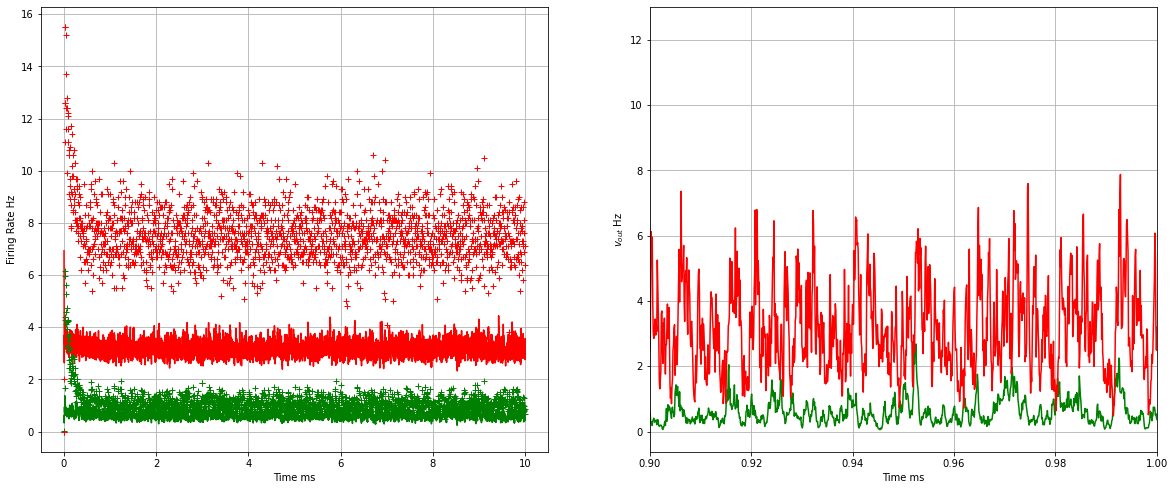

In [47]:
x_transp=np.transpose(x_trace_RS_with_noise)
TF_transp=np.transpose(TF_trace_RS_with_noise)

# RK terms 
ve=x_transp[0]#[1000:] # remove first 10000 elements
vi=x_transp[1]#[999:]
cee=x_transp[2]#[1000:] #cross correlation
cei=x_transp[3]#[1000:]
cie=x_transp[4]#[1000:]
cii=x_transp[5]#[1000:]
w=x_transp[6]

fig2=plt.figure(figsize=(20,18))
ax21=fig2.add_subplot(221)
ax22=fig2.add_subplot(222)

##### Load and plot the network activity of your choice ! #####

#BIN, TimBinned, popRateI,popRateIosc,popRateE,LfrG1,LfrG2,LfrG3=\
#np.load('../../PopRate_of_your_choice.npy',allow_pickle=True)
#ax21.plot(t_trace1,  ve1, color="green", label="excitory firing rate")
#ax21.plot(t_trace1, vi1, color="red", label="inhibitory firing rate")
#ax21.plot(TimBinned/1000,  popRateG1, color="blue", label="excitatory firing rate")
#ax21.plot(TimBinned/1000, popRateG2, color="yellow", label="inhibitory firing rate")
#ax21.plot(TimBinned/1000, popRateIosc, color="purple",ls="--", label="inhibitory firing rate")

ax21.plot(t_trace2,  ve, color="green", label="exc FR mean-field")
ax21.plot(t_trace2, vi, color="red", label="inh FR mean-field")
ax21.plot(TimBinned/1000,  popRateG2, 'g+', label="exc FR AdEx")
ax21.plot(TimBinned/1000, popRateG1, 'r+', label="inh FR AdEx")
#ax21.plot(t_trace, vib, color="orange",ls="--", label="inhibitory firing rate")

#ax21.plot(t_trace, cee, color="blue", label="inhibitory firing rate")
#ax21.plot(t_trace, ciaia, color="purple", label="inhibitory firing rate")
#ax21.plot(t_trace, cibib, color="yellow", label="inhibitory firing rate")

#ax21.set_ylim(0.1,10)
ax21.set_ylabel('Firing Rate Hz')
ax21.set_xlabel('Time ms')
ax21.grid(True)

###### Plot the instantaneous transfer functions #######

ax22.plot(t_trace2,  TF_transp[0], color="green", label="excitory TF")
ax22.plot(t_trace2, TF_transp[1], color="red", label="inhibitory TF")
#ax22.plot(t_trace, TF_transp_BNet_8p7[1], color="red",ls="--", label="inhibitory TF")
ax22.set_xlim(0.9,1)
#ax22.set_ylim(0,10)
ax22.set_ylabel('$v_{out}$ Hz')
ax22.set_xlabel('Time ms')
ax22.grid(True)

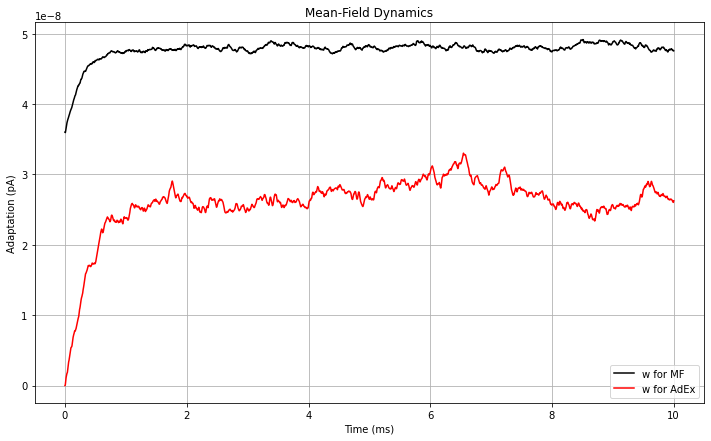

In [50]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace2,w*1e3,color="black",label="w for MF")
for a in range(Nrecord):
    #plt.plot(Ltime, LVG1[a],'r',label='RS cells') 
    plt.plot(Ltime/1000, (LwG2[a]+LwG1[a]),'r',label='w for AdEx')
    #plt.plot(Ltime, LVG2[a],'g',label='FS cells')
    #plt.plot(Ltime, LwG2[a],'g',label='FS cells')
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time (ms)")
plt.grid(True)
plt.ylabel("Adaptation (pA)")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,5e-8)
#plt.xlim(3,10)
plt.show()

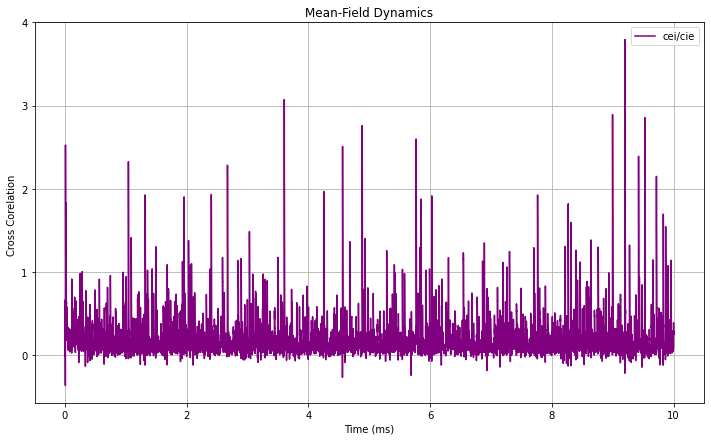

In [52]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace2, cei, color="purple", label="cei/cie")

plt.xlabel("Time (ms)")
plt.grid(True)
plt.ylabel("Cross Corelation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-0.01,0.1)
#plt.xlim(0,0.1)
plt.show()